In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import matplotlib
import scipy.stats as sps
import pandas as pd
import cupy as cp
from scipy.stats import norm, chi2
%matplotlib widget

# Plotting format for thesis
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('axes', titlesize=16, labelsize=16)
plt.rc('legend', fontsize=14)
plt.rc('figure', titlesize=18)

Fit parameters: a = 1.0000050040455755, b = 0.42994620933320615


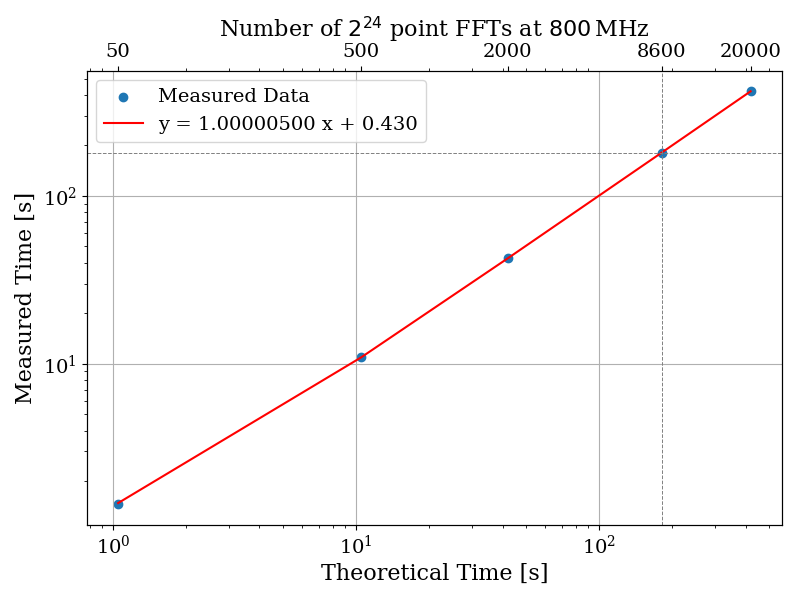

In [2]:
# DAQ efficiency 
# Data taken randomly on may 16 2024. 800MHz sample rate 2^24pt
theoryTime = [1.0486, 10.485, 41.943, 180.3551, 419.4304]
measuredTime = [1.4616, 10.936, 42.3741,180.7782, 419.8652]


# Define a linear function for fitting
def linear_fit(x, a, b):
    return a * x + b

# Perform the curve fit
params, params_covariance = curve_fit(linear_fit, theoryTime, measuredTime)

# Print fit parameters
print(f"Fit parameters: a = {params[0]}, b = {params[1]}")

# Generate data for the fit line
fit_line = linear_fit(np.array(theoryTime), *params)

# Calculate number of FFTs
sample_rate = 800e6
fft_points = 2**24
fft_time = fft_points / sample_rate
num_ffts = [time / fft_time for time in theoryTime]

# Plot data and fit

fig, ax1 = plt.subplots(figsize=(8, 6))

ax1.scatter(theoryTime, measuredTime, label='Measured Data')
ax1.plot(theoryTime, fit_line, label=f'y = {params[0]:.8f} x + {params[1]:.3f}', color='red')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel('Theoretical Time [s]')
ax1.set_ylabel('Measured Time [s]')
ax1.legend()
ax1.grid()


# Add a second x-axis
ax2 = ax1.twiny()
ax2.set_xscale('log')
ax2.set_xlim(ax1.get_xlim())
ax2.set_xlabel(r'Number of $2^{24}$ point FFTs at $800\,$MHz')
ax2.set_xticks(theoryTime)
ax2.set_xticklabels([f'{n:.0f}' for n in num_ffts])

plt.tight_layout()

# Highlight the 4th data point
index = 3
ax1.axvline(x=theoryTime[index], color='gray', linestyle='--', linewidth=0.7)
ax1.axhline(y=measuredTime[index], color='gray', linestyle='--', linewidth=0.7)


plt.show()



Text(-15.777777777777784, 0.5, 'Noise Temp of Cascaded System [K]')

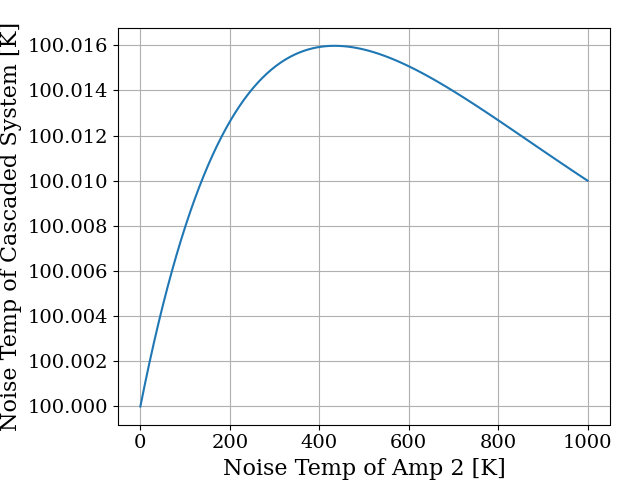

In [4]:
#not used
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


#Friis plot
G1 = np.linspace(40,50,100) #dB
G1 = 10**(G1/10)
T1 = 100 #K
T2 = np.linspace(0, 1000, 100) #K

def tempToF(T,T0 = 290):
    return 1+(T/T0)

def friis(G1, F1, F2):
    F1 = tempToF(T1)
    F2 = tempToF(T2)
    return F1 + ((F2-1)/G1)

def fToTemp(F, T0 = 290):
    return((F-1)*T0)

plt.close('all')
plt.figure()
plt.plot(T2, fToTemp(friis(G1, T1, T2)))
plt.grid()
plt.tight_layout(pad = 2)
plt.xlabel('Noise Temp of Amp 2 [K]')
plt.ylabel('Noise Temp of Cascaded System [K]')



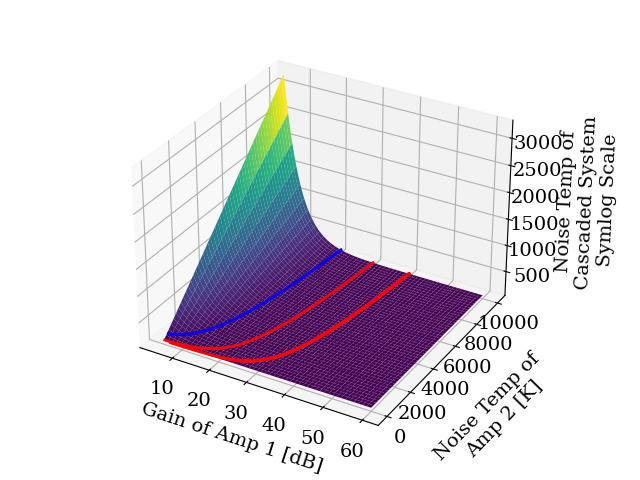

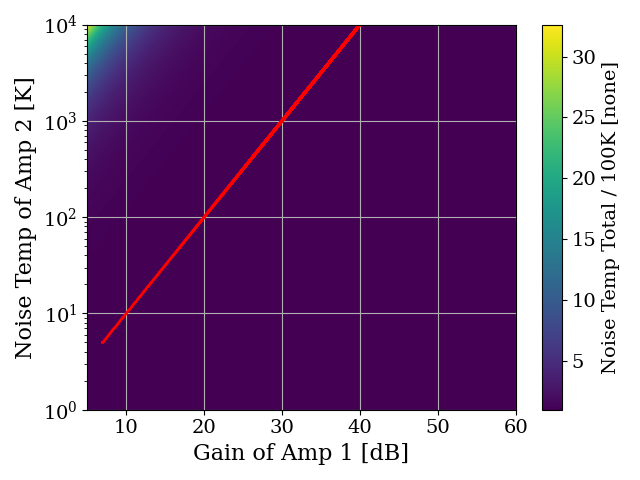

In [5]:
#cascade NF
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm


# Define parameters
G1 = np.linspace(5, 60, 5000)  # Gain in dB
T1 = 100  # K
T2 = np.linspace(1, 10000, 5000)  # Noise temperature in K

# Convert gain from dB to linear scale
G1_linear = 10**(G1/10)

# Create meshgrid for G1 and T2
G1_grid, T2_grid = np.meshgrid(G1_linear, T2)

# Define functions
def tempToF(T, T0=290):
    return 1 + (T / T0)

def friis(G1, T1, T2):
    F1 = tempToF(T1)
    F2 = tempToF(T2)
    return F1 + ((F2 - 1) / G1)

def fToTemp(F, T0=290):
    return (F - 1) * T0

# Calculate Friis noise temperature
friis_temp = fToTemp(friis(G1_grid, T1, T2_grid)) - 0

# Plotting
plt.close('all')
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(10*np.log10(G1_grid), T2_grid, friis_temp, cmap='viridis')
#ax.plot_surface(10*np.log10(G1_grid), T2_grid, np.full_like(G1_grid, fill_value=10), color='r', alpha=0.5)
'''
# Find intersection points and plot
G1_log = 10 * np.log10(G1_grid)
intersection_indices = np.abs(friis_temp - 1) < 1e-2

G1_intersection = G1_log[intersection_indices]
T2_intersection = T2_grid[intersection_indices]
z_intersection = friis_temp[intersection_indices]
'''

G1_log = 10 * np.log10(G1_grid)

# Find and plot intersections at 1, 10, and 100
colors = ['r', 'r', 'b']  # Define colors for each intersection value
intersection_values = [101, 110, 180]

for value, color in zip(intersection_values, colors):
    intersection_indices = np.abs(friis_temp - value) < 1e-2
    G1_intersection = G1_log[intersection_indices]
    T2_intersection = T2_grid[intersection_indices]
    z_intersection = friis_temp[intersection_indices]
    ax.plot(G1_intersection, T2_intersection, z_intersection, color+'-', linewidth=2, zorder=100, label=f'Intersection at {value}')



ax.plot(G1_intersection, T2_intersection, z_intersection, 'k-', linewidth=2, zorder = -100)

# Labels and title
ax.set_xlabel('Gain of Amp 1 [dB]', labelpad=6, fontsize=14)
ax.set_ylabel('Noise Temp of \nAmp 2 [K]', labelpad=14, fontsize=14)
ax.set_zlabel('Noise Temp of \nCascaded System \nSymlog Scale', labelpad=14, fontsize=14)
ax.yaxis.set_tick_params(pad = 0)
#ax.set_zscale('symlog')
#ax.legend(loc ='upper right', fontsize = 12)
plt.tight_layout(pad=2)
plt.grid()

plt.show()

# Additional 2D histogram plot
fig2, ax2 = plt.subplots()

# Plot 2D histogram
hist = ax2.hist2d(10*np.log10(G1_grid.flatten()), T2_grid.flatten(), bins=50, cmin=1, cmap='viridis')

# Overlay the noise temperature as a color mesh
#mesh = ax2.pcolormesh(10*np.log10(G1_grid), T2_grid, friis_temp, shading='auto', cmap='viridis')
mesh = ax2.pcolormesh(10*np.log10(G1_grid), (T2_grid), friis_temp/T1, shading='auto', cmap='viridis')

cbar = plt.colorbar(mesh, ax=ax2, )
cbar.set_label('Noise Temp Total / 100K [none]', fontsize = 14)


# Add a curve where the noise temp is approximately 101K
tempCurve = 101
approx_101_indices = (friis_temp > tempCurve-0.01) & (friis_temp < tempCurve+0.01)
#approx_101_indices = (friis_temp < tempCurve-0.01) 
G1_approx_101 = 10 * np.log10(G1_grid[approx_101_indices])
T2_approx_101 = T2_grid[approx_101_indices]

ax2.plot(G1_approx_101, T2_approx_101, 'r-', linewidth=2, alpha = 1)


# Labels and title
ax2.set_xlabel('Gain of Amp 1 [dB]')
ax2.set_ylabel('Noise Temp of Amp 2 [K]')
ax2.set_yscale('log')
ax2.grid()

plt.tight_layout()
plt.show()




/tmp/ipykernel_3657352/1643049919.py:16: RuntimeWarning: overflow encountered in exp
  return np.sqrt(eta * 8 * np.pi * h * nu**3/(c**2)* 1/(np.exp(h*nu/(k*temperature))-1))


red
orange
green
blue
purple


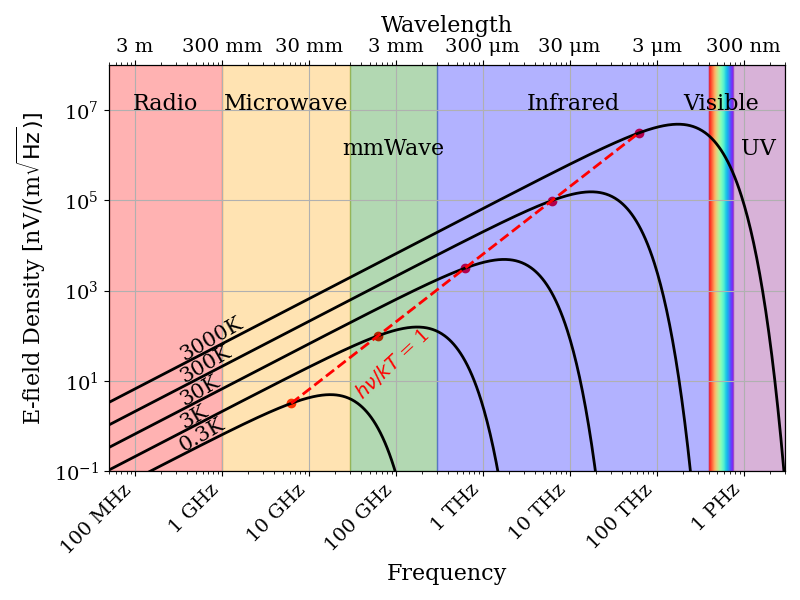

In [6]:
#black body E field plot

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter

# Constants
h = 6.626e-34  # Planck's constant in J*s
k = 1.381e-23  # Boltzmann constant in J/K
c = 3e8        # Speed of light in m/s

# Define the blackbody radiation function
def blackbody_radiation(nu, temperature):
    """Calculate blackbody radiation as a function of wavelength and temperature.""" 
    eta = 377 # Ohms
    return np.sqrt(eta * 8 * np.pi * h * nu**3/(c**2)* 1/(np.exp(h*nu/(k*temperature))-1))

# Define the range of freqs (in Hz)
nu = np.logspace(7, 15.7, 1000)  # from 1 nm to 3 µm

# Temperature in Kelvin
temperature = 300

# Calculate the blackbody radiation
EperRtHz = blackbody_radiation(nu, temperature)

tempList = [0.3, 3, 30 ,300,3000]

plt.close('all')
# Plot the blackbody radiation curve
fig, ax1 = plt.subplots(figsize=(8, 6))

for temp in tempList:
    ax1.plot(nu, blackbody_radiation(nu, temperature=temp) / 1e-9, label=f'T = {temp}K', linewidth=2, color='k') 
    ypos = blackbody_radiation(1e9, temperature=temp) / 1e-9  # label position in y
    ax1.text(3e8, ypos + (-.65 * ypos), s=f'{temp}K', rotation=30, fontsize=15, verticalalignment='bottom')

# Add the line for h nu = kT
critical_freqs = [k * temp / h for temp in [0.3, 3, 30 ,300,3000]]
critEfield = []
for critFreq, critTemp in zip(critical_freqs, tempList):
    critEfield.append(blackbody_radiation(critFreq, temperature=critTemp))
    ax1.scatter(critFreq, blackbody_radiation(critFreq, temperature=critTemp) / 1e-9, marker='o', color='r')
plt.plot(critical_freqs, np.asarray(critEfield)/1e-9, 'r--', linewidth = 2)
plt.text(3e10, 4,r'$h\nu/kT$ = 1', color = 'r', fontsize = 14, rotation = 43)


ax1.set_xlabel('Frequency')
ax1.set_ylabel(r'E-field Density [nV/(m$\sqrt{\mathrm{Hz}})]$')
ax1.grid(True)
ax1.loglog()
ax1.set_ylim(.1, 100000000)
ax1.set_xlim(5e7, 3e15)

# Add shaded regions for different wavelength ranges
wavelengths = {
    'Radio': (5e7, 1e9),
    'Microwave': (1e9, 30e9),
    'mmWave': (30e9, 300e9),
    'Infrared': (300e9, 4e14),
    'Visible': (4e14, 7.5e14),
    'UV': (7.5e14, 3e15),
}

colors = {
    'Radio': 'red',
    'Microwave': 'orange', 
    'mmWave' : 'green',
    'Infrared': 'blue',
    'Visible': None,  # Optical will be handled separately
    'UV': 'purple',
}

label_heights = {
    'Radio': 1e7,
    'Microwave': 1e7,
    'mmWave' : 1e6,
    'Infrared': 1e7,
    'Visible': 1e7,
    'UV': 1e6,
}

for label, (start, end) in wavelengths.items():
    if label == 'Visible':
        # Add reversed rainbow gradient for Optical region
        cmap = plt.get_cmap('rainbow')
        num_colors = 100  # Number of color segments
        frequencies = np.logspace(np.log10(start), np.log10(end), num_colors)
        for i in range(num_colors - 1):
            ax1.axvspan(frequencies[i], frequencies[i + 1], color=cmap((num_colors - i) / num_colors), alpha=0.3)
    else:
        print(colors[label])
        ax1.axvspan(start, end, color=colors[label], alpha=.3, label=label)
    
    ax1.text(np.exp((np.log(start) + np.log(end)) / 2), label_heights[label], label,
             horizontalalignment='center', rotation=0, fontsize=16)

# Function to format the x-axis labels
def format_func(value, tick_number):
    if value == 0:
        return "0"
    if value < 1e6:
        return f'{value / 1e3:.0f} kHz'
    elif value < 1e9:
        return f'{value / 1e6:.0f} MHz'
    elif value < 1e12:
        return f'{value / 1e9:.0f} GHz'
    elif value < 1e15:
        return f'{value / 1e12:.0f} THz'
    else:
        return f'{value / 1e15:.0f} PHz'

# Apply the formatter to the x-axis
ax1.xaxis.set_major_formatter(FuncFormatter(format_func))
plt.xticks(rotation=45, horizontalalignment='right')

# Create a second x-axis for wavelength
ax2 = ax1.twiny()

# Convert frequency to wavelength
#new_ticks = np.array([1e15, 1e14, 1e13, 1e12, 1e11, 1e10, 1e9, 1e8, 1e7])
new_ticks = np.array([1])
ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(new_ticks)
ax2.set_xscale('log')

# Function to format the wavelength labels
def wavelength_func(value, tick_number):
    if value == 0:
        return "0"
    wavelength = c / value
    if wavelength < 1e-9:
        return f'{wavelength * 1e12:.0f} pm'
    elif wavelength < 1e-6:
        return f'{wavelength * 1e9:.0f} nm'
    elif wavelength < 1e-3:
        return f'{wavelength * 1e6:.0f} μm'
    elif wavelength < 1:
        return f'{wavelength * 1e3:.0f} mm'
    else:
        return f'{wavelength:.0f} m'

# Apply the formatter to the second x-axis
ax2.xaxis.set_major_formatter(FuncFormatter(wavelength_func))
ax2.set_xlabel('Wavelength')

plt.tight_layout()
plt.show()


In [7]:
##Thermal noise voltage to PSD
 
# # thermal noise E-field [V/m/sqrt(Hz)]
# input voltage [V/sqrt(Hz)]
# output voltage //
# output power, one acquition [W/Hz]
#  

 # Parameters


N = 2**10  # Number of samples
Fs = 800e6    # Sampling frequency (Hz)
T = 1.0 / Fs # Sampling interval

p_sig = .0000  # power of signal [W]
p_noise = 10**(-20.4) * Fs/2   #W, Total ie S * Fs
f = 50e6       # Frequency of the sine wave (Hz)
Z = 50 #Ohms
numAvg = 10000

# Generate sine wave
V_peak = np.sqrt(p_sig*Z*2) #2 converts from RMS to peak 
V_noise = np.sqrt(p_noise*Z)

gpu = 1

if gpu: 
        # Convert time array to CuPy array
    t = cp.linspace(0.0, N*T, N, endpoint=False)

    # Averaging on GPU
    powSpec = cp.zeros(N//2)
    totalPowerList = []

    for i in range(numAvg):
        # Generate noise, build signal
        V_record = (
            V_peak * cp.sin(2.0 * cp.pi * f * t) 
            + cp.random.normal(0, V_noise, len(t))
        )
        
        # Perform FFT
        yf = cp.fft.rfft(V_record)
        
        totalPower = 2/N**2/Z * cp.sum(cp.abs(yf[:N//2])**2)
        totalPowerList.append(totalPower.get())  # Transfer only the final total power to the CPU
        
        if i % 100 == 0:
            print(i)
        
        # Normalize the FFT output to power spec
        powSpec += 2/N**2/Z * (cp.abs(yf[:N//2])**2)  # W/Hz

    # Transfer the final power spectrum back to CPU for plotting
    powSpec = cp.asnumpy(powSpec)
    V_record= cp.asnumpy(V_record)
    t= cp.asnumpy(t)
else:
    # Generate noisey signal wave
    t = np.linspace(0.0, N*T, N, endpoint=False)



    #averging
    powSpec = np.zeros(N//2)
    totalPowerList= []
    for i in range(numAvg):
        # Generate noise, build signal
        V_record = (
            V_peak * np.sin(2.0 * np.pi * f * t) 
            + np.random.normal(0, V_noise, len(t))
        )
        # Perform FFT
        yf = np.fft.rfft(V_record)
        totalPower = 2/N**2/Z * (np.abs(yf[:N//2])**2).sum()
        totalPowerList.append(totalPower)
        #print(f'total power = {totalPower}')
        if i % 100 == 0:
            print(i)
        # Normalize the FFT output to power spec
        powSpec += 2/N**2/Z * (np.abs(yf[:N//2])**2) #W/Hz
powSpec /= numAvg

# Plot the results

plt.close('all')


# Time domain plot
if 0:
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
    ax1.plot(t*1e6, V_record)
    ax1.set_title('Time Domain Signal')
    ax1.set_xlabel(r'Time [$\mu$s]')
    ax1.set_ylabel('Amplitude [V]')
    ax1.grid()

    # Frequency domain plot 
    freqs = np.linspace(0, Fs/2/1e6, N//2) #MHz
    ax2.plot(freqs, (powSpec))
    ax2.set_title('Frequency Domain (FFT)')
    ax2.set_xlabel('Frequency [MHz]')
    ax2.set_ylabel(r'Power Spectral Density [W/$\Delta \nu_\mathrm{RF}$]')
    ax2.grid()

    plt.tight_layout()
    plt.show()

if 0:
    plt.figure()
    plt.plot(t*1e6, V_record*1e6)
    plt.xlabel(r'Time [$\mu$s]')
    plt.ylabel(r'Measured Volatage [$\mu$V]')
    plt.grid()
    plt.tight_layout()
    plt.show()

print(f'total integrated noise power (therory) = {p_noise}')
print(f'total integrated power = {powSpec.sum()}')
print(f'mean power(per bin) = {np.mean(powSpec)}')
print(f'mean power(per bin)*num bins = {np.mean(powSpec)*N/2}')

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
total integrated noise power (therory) = 1.5924286822139943e-12
total integrated power = 1.5923211076714061e-12
mean power(per bin) = 3.110002163420715e-15
mean power(per bin)*num bins = 1.5923211076714061e-12


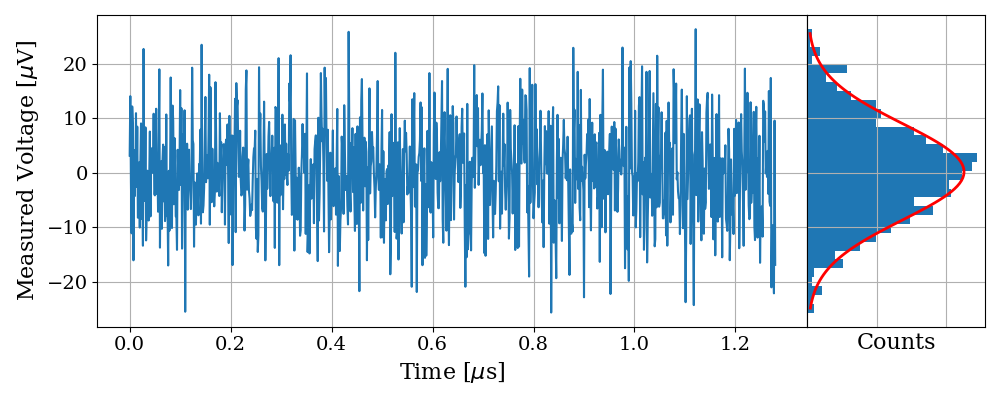

8.835639025670353 uV
mean = 0.1846972056626412 uV


In [8]:
#plot above
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
import cupy as cp
from scipy.stats import norm

# Ensure V_record is a NumPy array for plotting
V_record = cp.asnumpy(V_record)
t = cp.asnumpy(t)

# Create a figure with GridSpec to place the histogram on the right
fig = plt.figure(figsize=(10, 4))
gs = GridSpec(1, 2, width_ratios=[4, 1], wspace=0)

# Time domain plot on the left
ax1 = fig.add_subplot(gs[0])
ax1.plot(t * 1e6, V_record * 1e6)  # Convert CuPy array 't' to NumPy array for plotting
ax1.set_xlabel(r'Time [$\mu$s]')
ax1.set_ylabel(r'Measured Voltage [$\mu$V]')
ax1.grid()

# Histogram on the right
ax2 = fig.add_subplot(gs[1], sharey=ax1)

# Calculate the number of bins using the square-root choice
number_of_bins = int(np.ceil(np.sqrt(len(V_record))))
hist_data, bins, _ = ax2.hist(V_record * 1e6, bins=number_of_bins, orientation='horizontal', density=True)

# Fit a Gaussian to the histogram data
bin_centers = (bins[:-1] + bins[1:]) / 2
mu, std = norm.fit(V_record * 1e6)

# Plot the best-fit Gaussian
x = np.linspace(bin_centers.min(), bin_centers.max(), 100)
p = norm.pdf(x, mu, std)
ax2.plot(p, x, 'r-', linewidth=2)

# Remove ticks from the histogram
ax2.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelleft=False, labelbottom=False)

ax2.set_xlabel('Counts')
ax2.grid()

plt.tight_layout()
plt.show()
print(f'{np.std(V_record*1e6)} uV')
print(f'mean = {np.mean(V_record*1e6)} uV')

mu = 3.105614059893789
sigma = 0.10273461468915482


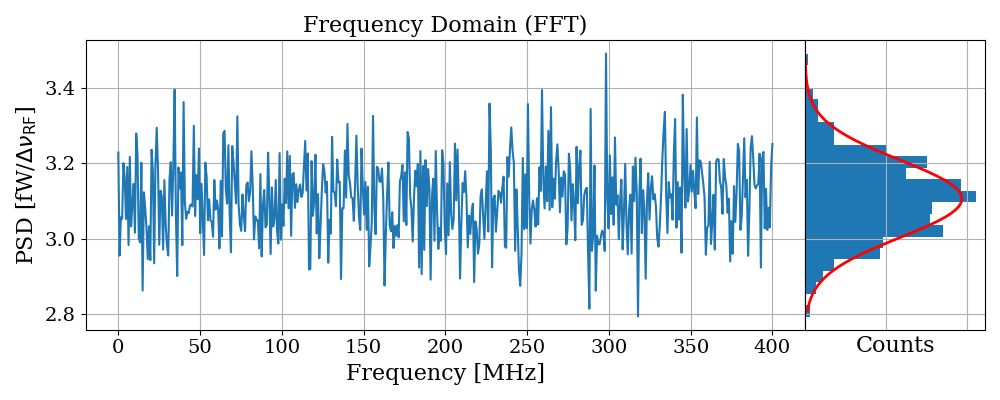

In [10]:
if numAvg!= 1:
    # Frequency domain plot with Gaussian fit
    fig = plt.figure(figsize=(10, 4))
    gs = GridSpec(1, 2, width_ratios=[4, 1], wspace=0)

    # Frequency domain plot on the left
    ax1 = fig.add_subplot(gs[0])
    freqs = np.linspace(0, Fs/2/1e6, N//2) # MHz
    ax1.plot(freqs, powSpec*1e15)
    ax1.set_title('Frequency Domain (FFT)')
    ax1.set_xlabel('Frequency [MHz]')
    ax1.set_ylabel(r'PSD [fW/$\Delta \nu_\mathrm{RF}$]')
    ax1.grid()

    # Histogram on the right
    ax2 = fig.add_subplot(gs[1], sharey=ax1)

    # Calculate the number of bins using the square-root choice
    number_of_bins = int(np.ceil(np.sqrt(len(powSpec))))
    hist_data, bins, _ = ax2.hist(powSpec*1e15, bins=number_of_bins, orientation='horizontal', density=True)

    # Fit a Gaussian to the histogram data
    bin_centers = (bins[:-1] + bins[1:]) / 2
    mu, std = norm.fit(powSpec*1e15)
    print(f'mu = {mu}')
    print(f'sigma = {std}')
    # Plot the best-fit Gaussian
    x = np.linspace(bin_centers.min(), bin_centers.max(), 100)
    p = norm.pdf(x, mu, std)
    ax2.plot(p, x, 'r-', linewidth=2)

    # Remove ticks from the histogram
    ax2.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelleft=False, labelbottom=False)

    ax2.set_xlabel('Counts')
    ax2.grid()

    plt.tight_layout()
    plt.show()

else:
    # Frequency domain plot with Chi-Squared fit (1 degree of freedom)
    fig = plt.figure(figsize=(10, 4))
    gs = GridSpec(1, 2, width_ratios=[4, 1], wspace=0)

    # Frequency domain plot on the left
    ax1 = fig.add_subplot(gs[0])
    freqs = np.linspace(0, Fs/2/1e6, N//2) # MHz
    ax1.plot(freqs, powSpec*1e15)

    ax1.set_xlabel('Frequency [MHz]')
    ax1.set_ylabel(r'PSD [fW/$\Delta \nu_\mathrm{RF}$]')
    ax1.grid()

    # Histogram on the right
    ax2 = fig.add_subplot(gs[1], sharey=ax1)

    # Calculate the number of bins using the square-root choice
    number_of_bins = int(np.ceil(np.sqrt(len(powSpec))))
    hist_data, bins, _ = ax2.hist(powSpec*1e15, bins=number_of_bins, orientation='horizontal', density=True)

    # Fit a Chi-Squared distribution to the histogram data
    bin_centers = (bins[:-1] + bins[1:]) / 2
    df = 1
    chi2_params = chi2.fit(powSpec, df)
    print(f'X^2 parameters (loc, scale) = {chi2_params[1:]} [W] not in pW!!!!')

    # Plot the best-fit Chi-Squared
    x = np.linspace(bin_centers.min(), bin_centers.max(), 100)
    p = chi2.pdf(x, df, *chi2_params[1:])
    #ax2.plot(p, x, 'r-', linewidth=2)

    # Remove ticks from the histogram
    ax2.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelleft=False, labelbottom=False)

    ax2.set_xlabel('Counts')
    ax2.grid()

    plt.tight_layout(pad=1.3)
    plt.show()

Average 0/4
Average 0/16
Average 0/64
Average 0/256
Average 100/256
Average 200/256
Average 0/1012
Average 100/1012
Average 200/1012
Average 300/1012
Average 400/1012
Average 500/1012
Average 600/1012
Average 700/1012
Average 800/1012
Average 900/1012
Average 1000/1012


/tmp/ipykernel_3657352/2776583579.py:98: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


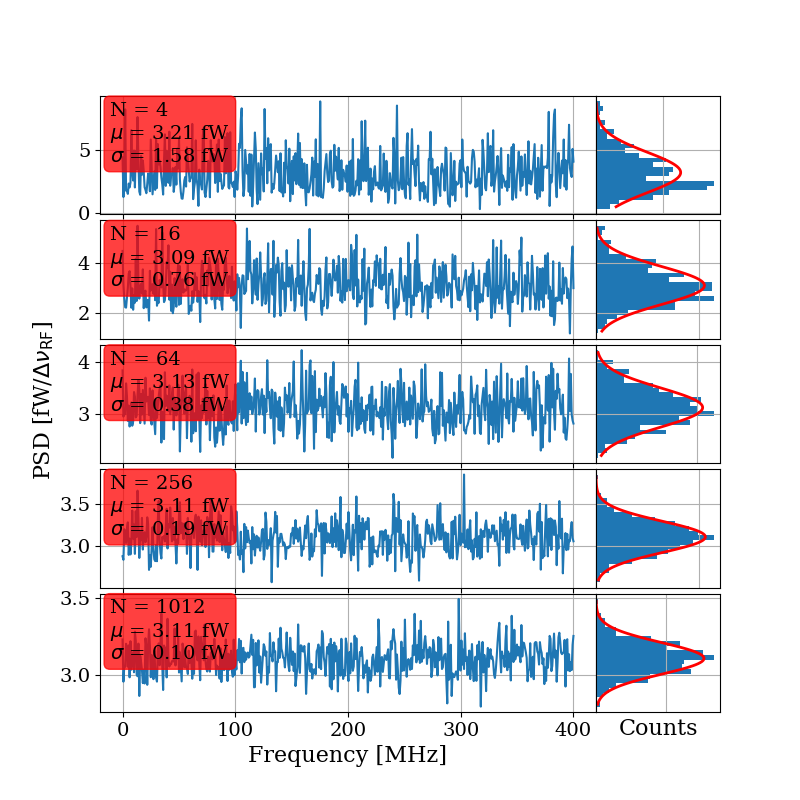

In [9]:
#x^2 to gaussian 

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from matplotlib.gridspec import GridSpec

# Define the parameters
N = 2**10  # Number of samples
Fs = 800e6  # Sampling frequency (Hz)
T = 1.0 / Fs  # Sampling interval

p_sig = .0000  # power of signal [W]
p_noise = 10**(-20.4) * Fs/2  # W, Total ie S * Fs
f = 50e6  # Frequency of the sine wave (Hz)
Z = 50  # Ohms
numAvgList = [4, 16, 64, 256, 1012]  # List of number of averages

# Generate time array
t = np.linspace(0.0, N*T, N, endpoint=False)

# Create a figure with subplots
fig = plt.figure(figsize=(8, 8))
gs = GridSpec(5, 2, width_ratios=[4, 1], hspace=0.05, wspace=0)

# Iterate over the list of number of averages
for idx, numAvg in enumerate(numAvgList):
    # Averaging
    powSpec = np.zeros(N//2)
    totalPowerList = []

    for i in range(numAvg):
        # Generate noise, build signal
        V_record = (
            np.sqrt(p_sig*Z*2) * np.sin(2.0 * np.pi * f * t) 
            + np.random.normal(0, np.sqrt(p_noise*Z), len(t))
        )
        
        # Perform FFT
        yf = np.fft.rfft(V_record)
        
        totalPower = 2/N**2/Z * np.sum(np.abs(yf[:N//2])**2)
        totalPowerList.append(totalPower)  # Store total power
        
        if i % 100 == 0:
            print(f'Average {i}/{numAvg}')
        
        # Normalize the FFT output to power spec
        powSpec += 2/N**2/Z * (np.abs(yf[:N//2])**2)  # W/Hz

    # Normalize the power spectrum by the number of averages
    powSpec /= numAvg

    # Frequency domain plot
    freqs = np.linspace(0, Fs/2/1e6, N//2)  # MHz
    ax1 = fig.add_subplot(gs[idx, 0])
    ax1.plot(freqs, powSpec * 1e15)
    ax1.grid()
    if idx == len(numAvgList) - 1:
        ax1.set_xlabel('Frequency [MHz]')
    else:
        ax1.tick_params(labelbottom=False)

    # Add text box with title, mean, and std
    mu, std = norm.fit(powSpec * 1e15)
    textstr = f'N = {numAvg}\n$\\mu$ = {mu:.2f} fW\n$\\sigma$ = {std:.2f} fW'



    ax1.text(0.02, 0.95, textstr, transform=ax1.transAxes, fontsize=14,
             verticalalignment='top', bbox=dict(boxstyle='round', alpha=.75, color = 'red'))

    # Histogram on the right
    ax2 = fig.add_subplot(gs[idx, 1], sharey=ax1)
    
    # Calculate the number of bins using the square-root choice
    number_of_bins = int(np.ceil(np.sqrt(len(powSpec))))
    hist_data, bins, _ = ax2.hist(powSpec * 1e15, bins=number_of_bins, orientation='horizontal', density=True)
    
    # Fit a Gaussian to the histogram data
    bin_centers = (bins[:-1] + bins[1:]) / 2
    
    # Plot the best-fit Gaussian
    x = np.linspace(bin_centers.min(), bin_centers.max(), 100)
    p = norm.pdf(x, mu, std)
    ax2.plot(p, x, 'r-', linewidth=2)
    
    # Remove ticks from the histogram
    ax2.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelleft=False, labelbottom=False)
    
    if idx == len(numAvgList) - 1:
        ax2.set_xlabel('Counts')
    ax2.grid()

# Set common y-axis label
fig.text(0.04, 0.5, r'PSD [fW/$\Delta \nu_\mathrm{RF}$]', va='center', rotation='vertical', fontsize = 16)

plt.tight_layout()
plt.show()


In [227]:
#this is really in system design section
from scipy.interpolate import interp1d

# Load data from the text file
filename = './comPowerAF10m.txt'
data_from_file = np.loadtxt(filename, delimiter=',')
AF_freqs = data_from_file[:, 0]
AF = data_from_file[:, 1]

fileName         = '/drBiggerBoy/run1p4/plottingSpec/chA_avg_W_switch1.npy' 
freqs       = np.linspace(0,400,2**23+1)[1:-1]
data = np.load(fileName)[1:-1]


# Interpolating the Antenna Factor
AF_interp = np.interp(freqs, AF_freqs, 10**(AF/20))
#plt.plot(freqs, AF_interp)


# Conversion function from dBm to V/m with interpolated antenna factor
def V_per_m_to_dBm(Vpm):
    volt = Vpm/AF_interp 
    powerW = volt**2/50
    powerdBm = 10*np.log10(powerW*1000)
    return powerdBm



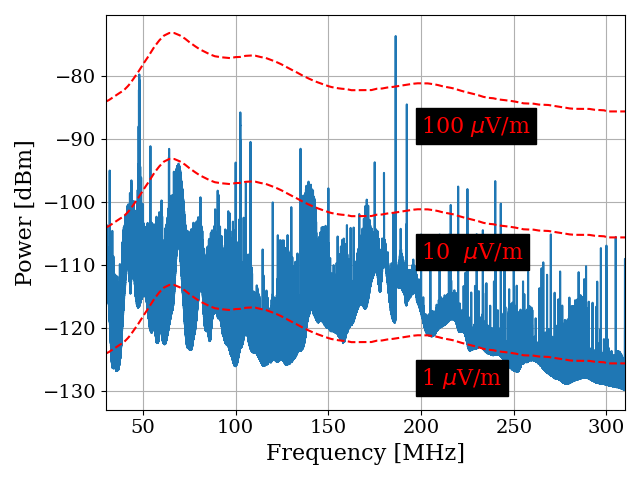

In [228]:
plt.close('all')
# Plotting the original data
plt.plot(freqs, 10 * np.log10(data * 1000), label='Power [dBm]')
plt.xlabel('Frequency [MHz]')
plt.ylabel('Power [dBm]')
plt.grid(True)


# Reference lines in dBm
field_strength_values = [1e-4,1e-5,1e-6]

for Vpm in field_strength_values:
    dBm = V_per_m_to_dBm(Vpm)
    plt.plot(freqs, dBm, 'r--')

#plt.text(275, -73.5 , f'1 mV/m', fontsize=16, color='r', verticalalignment='bottom', backgroundcolor='black')
plt.text(200, -90 , r'100 $\mu$V/m', fontsize=16, color='r', verticalalignment='bottom', backgroundcolor='black')
plt.text(200, -110 , r'10  $\mu$V/m', fontsize=16, color='r', verticalalignment='bottom', backgroundcolor='black')
plt.text(200, -130 , r'1 $\mu$V/m', fontsize=16, color='r', verticalalignment='bottom', backgroundcolor='black')


plt.tight_layout()
plt.xlim(30,310)
plt.show()